<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter05/threshold_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from numpy import argmax
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Synthetic data set prep:

y_train:  Counter({0: 39404, 1: 596})
y_test:  Counter({0: 9851, 1: 149})


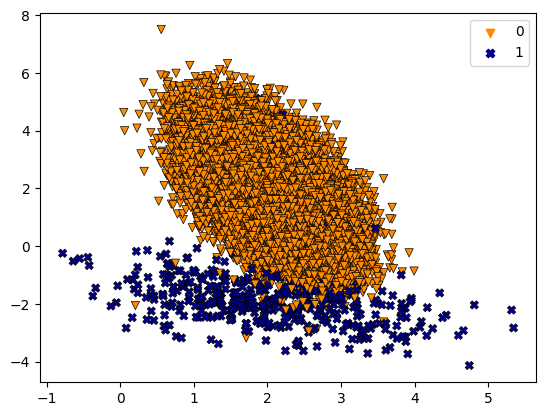

In [2]:
def plot_dataset(X, y):
  cmap_bold = ["darkorange", "darkblue"]
  markers = {1: "X", 0: "v"}
  sns.scatterplot(
      x=X[:, 0],
      y=X[:, 1],
      hue=y,
      palette=cmap_bold,
      alpha=1.0,
      edgecolor="black",
      style=y, markers=markers
  )

X, y = make_classification(n_samples=50000,
                      n_features=2,
                      n_redundant=0,
                      n_clusters_per_class=1,
                      weights=[0.99],
                      class_sep=2,
                      random_state=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

plot_dataset(X_train, y_train)

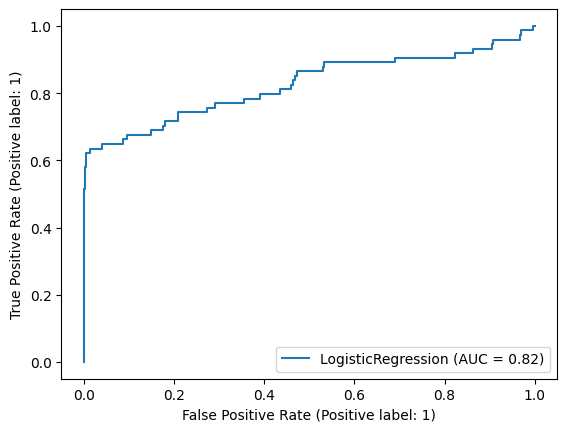

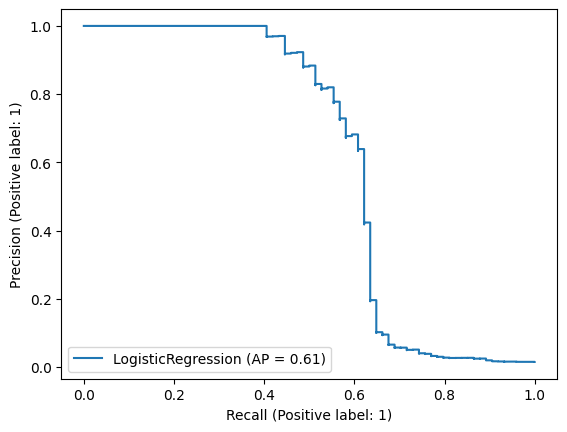

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)
y_pred = y_pred[:, 1]

RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.show()

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)
plt.show()

In [4]:
def convert_prob_to_labels(pos_probs, threshold):
  return (pos_probs >= threshold).astype(int)

# Threshold tuning using prior threshold
Compute prior threshold using the class imbalance ratio

In [5]:
num_positive_class_examples, num_negative_class_examples = Counter(y)[1], Counter(y)[0]
prior_threshold = num_positive_class_examples/(num_positive_class_examples+num_negative_class_examples)
print('Prior threshold=%f'% prior_threshold)

# find closest threshold from the thresholds obtained from roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
min_threshold_index = np.absolute(thresholds-prior_threshold).argmin()
print('Best threshold using prior threshold from ROC function=%f'% thresholds[min_threshold_index])
print("TPR value at the threshold=%f" % tpr[min_threshold_index])
print("FPR value at the threshold=%f" % fpr[min_threshold_index])
print("TNR value at the threshold=%f" % (1-fpr[min_threshold_index]))

y_pred_class = convert_prob_to_labels(y_pred, thresholds[min_threshold_index])
confusion_matrix(y_test, y_pred_class)

Prior threshold=0.014900
Best threshold using prior threshold from ROC function=0.014232
TPR value at the threshold=0.675676
FPR value at the threshold=0.147990
TNR value at the threshold=0.852010


array([[4197,  729],
       [  24,   50]])

# Threshold tuning using ROC curve

### We try to maximize Youden's index here in order to find the optimal threshold using ROC curve

In [6]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
youden_index = tpr - fpr
max_youden_index = np.argmax(youden_index)
best_thresh = thresholds[max_youden_index]
print('Best threshold using Youden index=%f'% best_thresh)
print('Max Youden index value=%f'% youden_index[max_youden_index])
print("TPR value at the threshold=%f" % tpr[max_youden_index])
print("FPR value at the threshold=%f" % fpr[max_youden_index])
print("TNR value at the threshold=%f" % (1-fpr[max_youden_index]))

y_pred_class = convert_prob_to_labels(y_pred, best_thresh)
confusion_matrix(y_test, y_pred_class)

Best threshold using Youden index=0.098879
Max Youden index value=0.622143
TPR value at the threshold=0.635135
FPR value at the threshold=0.012992
TNR value at the threshold=0.987008


array([[4862,   64],
       [  27,   47]])

### We try to maximize geometric mean of TPR and FPR to compute the optimal threshold using ROC curve

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmean = np.sqrt(tpr*(1-fpr))
max_gmean_index=np.argmax(gmean)

best_thresh = thresholds[max_gmean_index]
print('Best threshold using G-mean=%f'% (best_thresh))
print('Max G-mean value=%f'% (gmean[max_gmean_index]))
print("TPR value at the threshold=%f" % tpr[max_gmean_index])
print("FPR value at the threshold=%f" % fpr[max_gmean_index])
print("TNR value at the threshold=%f" % (1-fpr[max_gmean_index]))

y_pred_class = convert_prob_to_labels(y_pred, best_thresh)
confusion_matrix(y_test, y_pred_class)

Best threshold using G-mean=0.098879
Max G-mean value=0.791760
TPR value at the threshold=0.635135
FPR value at the threshold=0.012992
TNR value at the threshold=0.987008


array([[4862,   64],
       [  27,   47]])

# Threshold tuning using PR curve

Let's try to find the most optimal threshold by optimizing the fscore metric which is defined as the harmonic mean of precision and recall


max_fscore_idx==4950
best threshold using PR curve=0.258727
max(fscore)=0.661290


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Text(0, 0.5, 'precision')

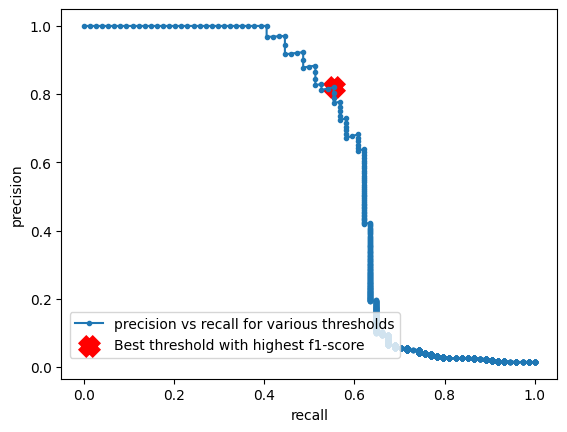

In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = 2*precision*recall/(precision+recall)

max_fscore_idx = argmax(fscore)
print('max_fscore_idx==%d' % max_fscore_idx)
print('best threshold using PR curve=%f' % thresholds[max_fscore_idx])
print('max(fscore)=%f' % fscore[max_fscore_idx])

plt.plot(recall, precision, marker='.', label='precision vs recall for various thresholds')
result = plt.scatter(recall[max_fscore_idx], precision[max_fscore_idx],
                        marker='x', color='red', linewidths=15,
                        label='Best threshold with highest f1-score')

plt.legend(handles=result.legend_elements()[0], labels="legend", loc='upper center', bbox_to_anchor=(0.35, 0.2))
plt.xlabel('recall')
plt.ylabel('precision')


# Custom metric
Let's assume we have a custom metric to optimize, then we can write a custom function to find the threshold that optimizes that metric.

Here we use the f1-score as our custom metric.

In [9]:
"""
Index of union method: IU(c) = (|Sensitivity(c) − ROC_AUC| + |Specificity(c) − ROC_AUC|)
Find c such that IU(c) is minimized
Reference: I. Unal, “Defining an Optimal Cut-Point Value in ROC Analysis: An Alternative Approach
"""
def custom_metric(y_test, y_pred):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  sensitivity = tpr
  specificity = 1-fpr #same as tnr
  roc_auc = auc(fpr, tpr)
  index_of_union = abs(sensitivity-roc_auc) + abs(specificity-roc_auc)
  return index_of_union

scores = custom_metric(y_test, y_pred)
min_score_idx = np.argmin(scores)
print('max_score_idx=%d' % min_score_idx)
print('best threshold=%f'% thresholds[min_score_idx])
print('minimum IU-value at the best threshold=%f' % scores[min_score_idx])


max_score_idx=34
best threshold=0.000042
minimum IU-value at the best threshold=0.112514
